Crearemos ahora tres nubes de puntos distintas. Una parte crucial es que nuestras etiquetas y ya no serán un solo número. Las convertiremos a un formato llamado one-hot encoding, que es lo que la Entropía Cruzada Categórica espera. Por ejemplo, la Clase 2 (``[2]``) se convierte en un vector ``[0, 0, 1]``.

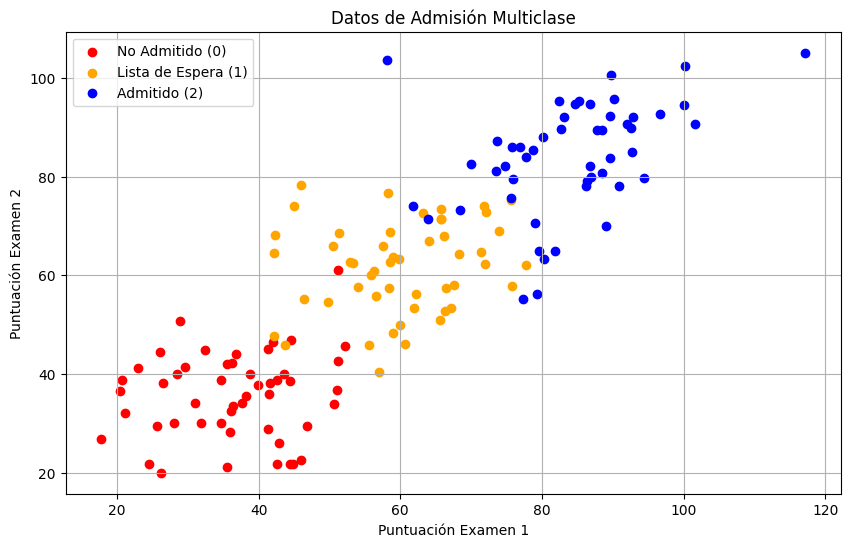

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Para resultados reproducibles
np.random.seed(42)

num_students_per_class = 50
num_classes = 3

# Generar datos para las 3 clases
mean_0 = [35, 35] # No Admitido
mean_1 = [60, 60] # Lista de Espera
mean_2 = [85, 85] # Admitido Directamente
cov = [[100, 30], [30, 100]] # Covarianza para la forma de la nube

X0 = np.random.multivariate_normal(mean_0, cov, num_students_per_class)
X1 = np.random.multivariate_normal(mean_1, cov, num_students_per_class)
X2 = np.random.multivariate_normal(mean_2, cov, num_students_per_class)

# Combinar características
X = np.vstack((X0, X1, X2))

# Crear etiquetas (0, 1, 2)
y_indices = np.array([0]*num_students_per_class + [1]*num_students_per_class + [2]*num_students_per_class)

# **One-Hot Encoding de las etiquetas**
m = len(y_indices)
Y_one_hot = np.zeros((m, num_classes))
Y_one_hot[np.arange(m), y_indices] = 1

# Visualizar los datos
plt.figure(figsize=(10, 6))
plt.scatter(X0[:, 0], X0[:, 1], color='red', label='No Admitido (0)')
plt.scatter(X1[:, 0], X1[:, 1], color='orange', label='Lista de Espera (1)')
plt.scatter(X2[:, 0], X2[:, 1], color='blue', label='Admitido (2)')
plt.title('Datos de Admisión Multiclase')
plt.xlabel('Puntuación Examen 1')
plt.ylabel('Puntuación Examen 2')
plt.legend()
plt.grid(True)
plt.show()

El código es similar al de la regresión logística, pero ahora los pesos ``W`` son una matriz (num_features x num_classes) y la hipótesis usa la función softmax.

In [7]:
def softmax(z):
    """Calcula la función softmax de forma numéricamente estable."""
    # Restar el máximo de z para evitar overflow en np.exp()
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cost_function_softmax(Y_one_hot, P_hat):
    """Calcula el coste de Entropía Cruzada Categórica."""
    m = Y_one_hot.shape[0]
    epsilon = 1e-9
    cost = - (1/m) * np.sum(Y_one_hot * np.log(P_hat + epsilon))
    return cost

def train_softmax_regression(X, Y_one_hot, alpha, epochs):
    """Entrena el modelo Softmax."""
    m, n_features = X.shape
    n_classes = Y_one_hot.shape[1]

    # 1. Añadir el término de sesgo a X
    X_b = np.c_[np.ones((m, 1)), X]

    # 2. Inicializar la matriz de pesos W (features x classes)
    W = np.zeros((n_features + 1, n_classes))

    cost_history = []

    # 3. Bucle de descenso de gradiente
    for i in range(epochs):
        # Calcular los scores (logits)
        scores = X_b @ W

        # Calcular las probabilidades con softmax
        P_hat = softmax(scores)

        # Calcular el gradiente
        gradient = (1/m) * (X_b.T @ (P_hat - Y_one_hot))

        # Actualizar la matriz de pesos
        W = W - alpha * gradient

        # Registrar el coste
        cost = cost_function_softmax(Y_one_hot, P_hat)
        cost_history.append(cost)

    return W, cost_history

# Hiperparámetros
alpha = 0.01
epochs = 50000

# Entrenar el modelo
Weights_softmax, costs_softmax = train_softmax_regression(X, Y_one_hot, alpha, epochs)

print("Forma de la matriz de pesos finales W:", Weights_softmax.shape)

Forma de la matriz de pesos finales W: (3, 3)


Visualizar esto es más complejo que dibujar una sola línea. Lo que haremos es crear una malla de puntos en todo el gráfico, predecir la clase para cada punto de la malla y colorear cada región según la clase predicha. Esto nos dará un hermoso "mapa de decisión".

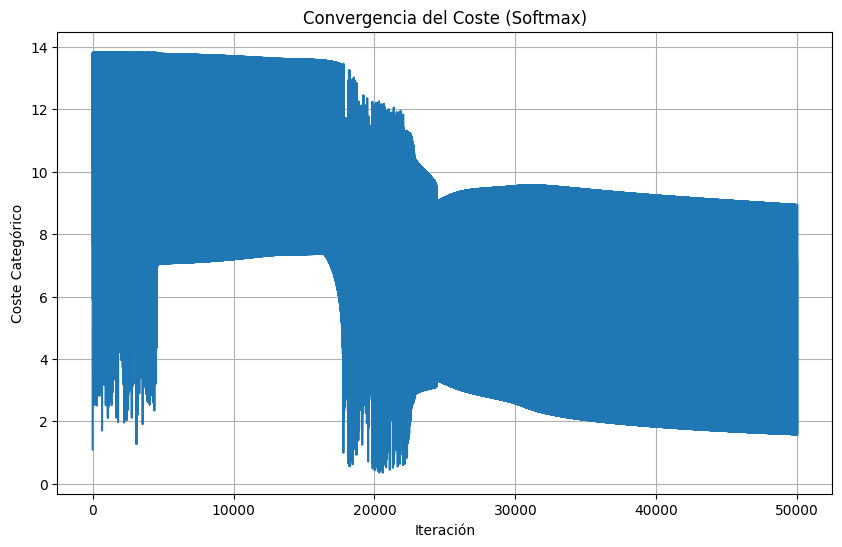

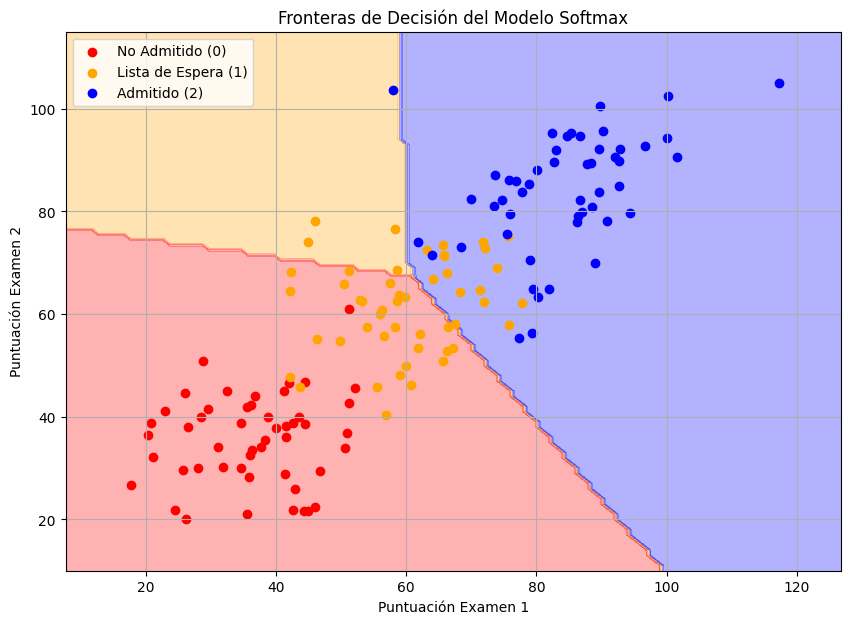

In [8]:
from matplotlib.colors import ListedColormap
# Visualizar la convergencia del coste
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), costs_softmax)
plt.title('Convergencia del Coste (Softmax)')
plt.xlabel('Iteración')
plt.ylabel('Coste Categórico')
plt.grid(True)
plt.show()

# Crear una malla para visualizar las regiones de decisión
x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# Predecir para cada punto de la malla
mesh_data = np.c_[xx.ravel(), yy.ravel()]
mesh_data_b = np.c_[np.ones((mesh_data.shape[0], 1)), mesh_data]

mesh_scores = mesh_data_b @ Weights_softmax
mesh_probs = softmax(mesh_scores)
Z = np.argmax(mesh_probs, axis=1)
Z = Z.reshape(xx.shape)

# Graficar las regiones y los datos
custom_colors = ['red', 'orange', 'blue']
custom_cmap =  ListedColormap(custom_colors)
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=custom_cmap)

plt.scatter(X0[:, 0], X0[:, 1], color='red', label='No Admitido (0)')
plt.scatter(X1[:, 0], X1[:, 1], color='orange', label='Lista de Espera (1)')
plt.scatter(X2[:, 0], X2[:, 1], color='blue', label='Admitido (2)')

plt.title('Fronteras de Decisión del Modelo Softmax')
plt.xlabel('Puntuación Examen 1')
plt.ylabel('Puntuación Examen 2')
plt.legend()
plt.grid(True)
plt.show()

Resultado y Conclusión Práctica: La gráfica final es la más reveladora. Muestra el espacio de decisión dividido en tres regiones de color. La región roja corresponde a la predicción "No Admitido", la naranja a "Lista de Espera" y la azul a "Admitido Directamente". Las líneas que separan estas regiones son las fronteras de decisión aprendidas. El modelo ha dividido con éxito el espacio de características para clasificar a los nuevos estudiantes en una de las tres categorías, demostrando el poder de la Regresión Softmax para problemas multiclase.